### Классификация разрядов молний по данным локаторов с машинным обучением.

##### Фурлетов Никита 2023 г.

#### 1. Цель и описание
Данный проект нацелен на улучшение классификации молний по радару.

Цель:
- Превзойти классификацию, основанную на y-параметре.
- Сделать развёрнутый анализ радарной информации для задачи классификации гидрометеоров.

Данные:
Для работы использовались данные с локаторов 26061 - РГГМУ, 26850 - Минск за 2021г. <br />
Данные грозопеленгационной сети - blitzortung

Параметры:
- Отражаемость, высота облачности, явление  <br />

Дополнительно (только для базовой классификации по одной ячейке):
- Радиальная скорость
- Ширина спектра
- Дифференциальная отражаемость
- Дифференциальная фаза

Получилось два решения задачи:
 - Классификация по одной ячейке (1x1) - basic_#####.ipynb
 - Классификация блока (5х5) - block_#####.ipynb
 , где ##### - номер радара.
 
Статья по блочной классификации: https://www.researchgate.net/publication/360419780_Monitoring_Lightning_Location_Based_on_Deep_Learning_Combined_with_Multisource_Spatial_Data


Ограничения:
***Необходимо как минимум 64 гб RAM для анализа от 2 тыс сроков.***

#### 2. Структура проекта

### data - Папка с данными 
binary data - Данные радара в бинарном формате. <br />
data_BO - blitzortung грозопеленгационные данные <br />
ASTER - данные DEM (Цифровой модели рельефа, только 26061, не использовались) <br />

***interim - промежуточные и итоговые данные***

Форматы: <br />
.parquet - оптимизированный формат для таблиц pandas.DataFrame <br />
.npy - сохранённый numpy.array 
- df_blitz_#####.parquet - грозопеленгационные данные в таблице.
- stack_#####.npy - Основной файл со всей информацией по одному локатору. Размерность (Срок, Х, Y, параметры(DWR_preprocess.get_stacked_array))
- basic_classif_#####.parquet - данные для базового анализа.
- 

lightning_stack_##### - данные для классификации блока

numpy_data - данные для обучения модели


### docs - текстовые документы
### figures - графики (устаревшие)
### models - модели
### notebooks

- basic_#####.ipynb - Классификация по одной ячейке (1x1), анализ радиолокационной информации, кластеризация
- block_#####.ipynb - Классификация блока (5х5)
- EDA.ipynb - Исследовательский Анализ Данных, черновик
- data_eng.ipynb - черновик для обработки данных
- Lightning classification via radar data main - основной
- regression - попытка прогнозировать количество разрядов в ячейке
- old_notebooks - устаревште ноутбуки, могут быть полезны

***DWR_preprocess.py*** - "библиотека" для данного проекта

requirements.txt - зависимости <br />
lightning-env.txt - conda environment <br />
github - версии

#### 3. Предобработка данных

Источник данных - 192.168.2.210 <br />

Для работы использовались бинарные радарные данные, загруженные в папку binary data <br />
*Например - /home/meteofurletov/iram/lightning/data/binary data/S26061/G2020/M01/D01/000001.01A*

и данные грозопеленгаторов в data_BO. (BO - BlitzOrtung).

Для перевода данных грозопеленгаторов на радарную сетку и формирования np.array для дальнейшей работы ф. используется *blitzortung_preprocessing* 

In [51]:
from DWR_preprocess import *

station_number = 26061 # код станции
year_regex = '2021'    # год 

In [52]:
blitzortung_array = blitzortung_preprocessing(station_number, matrix_shape=200, year_regex=year_regex, path_to_binary=Paths.binary)

Latitude is 59.92167, Longitude is 30.40806
Blitzortung data is already converted
Array shape is: (2164, 200, 200)


Обработка радарной информации. 

In [3]:
radar_array = radar_preprocessing(station_number, year_regex=year_regex, path_to_binary=Paths.binary, path_to_save=Paths.numpy_data, n_extra_files=500, doppler=False)

phen data is already converted
echo_top data is already converted
reflectivity data is already converted
prop data is already converted
Converting to numpy


100%|██████████| 2533/2533 [00:03<00:00, 736.61it/s]


Shape of radar array: (2533, 200, 200, 19)


Конкатенация в stack.npy.

In [4]:
stack = concatenate_data(radar_array, blitzortung_array, station_number=station_number, year_regex=year_regex)

All data converted and saved!


stack.npy - основные данные.

- Для базовой классификации перейдите в basic_#####.ipynb
- Для блоковой продолжите в этом ноутбуке.


***Здесь рекомендуется перезапустить ноутбук!***

## Sliding Window 

Для перехода к блокам, необходимо реализовать скользящее окно к трёхмерным данным. В результате, получается огромный массив данных (около 800гб). Используется dask для ленивой обработки данных.

In [59]:
import numpy as np
from DWR_preprocess import *

import warnings
warnings.filterwarnings("ignore")

station_number = 26061
window = 5

In [60]:
# загрузка ранее подготовленого stack
stack = np.load(Paths.interim + f'stack_{station_number}.npy')
stack.shape

(2533, 200, 200, 20)

Массив нужно разбить на одинаковые батчи, высчитываются делители числа, подберите число около 500-1500, в зависимости от объёма RAM и занесите в split value. Если делителей нет в данном интервале, удалите сроки для подбора нужного числа. 

К примеру:

In [61]:
#n_to_delete = 1
#stack = np.delete(stack, (np.arange(n_to_delete)), 0) - для удаления
factors(stack.shape[0])

{1, 17, 149, 2533}

In [62]:
n_to_delete = 1
stack = np.delete(stack, (np.arange(n_to_delete)), 0) #- для удаления
factors(stack.shape[0])

{1, 2, 3, 4, 6, 12, 211, 422, 633, 844, 1266, 2532}

In [63]:
# Предобработка блоков для упрощения и ускорения ленивых расчётов
precomputing(stack, station_number, window, distribution=np.random.uniform, value=0.03)

target is already computed
delta is already computed


In [11]:
%%time
# алгоритм сдвигающегося окна, реализованного на dask.
window_data_filter(stack, split_value=1266, window=5, station_number=station_number)

Iteration: 0
Iteration data is 
 dask.array<reshape, shape=(48634656, 5, 5, 20), dtype=int32, chunksize=(1190896, 5, 5, 20), chunktype=numpy.ndarray>
TF: false-(48613920,), true-(20736,)


  0%|          | 0/44 [00:00<?, ?it/s]

Remaining percent  = 3.0


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

TF processed 
 : false-(415462,), true-(19589,)
Iteration result is 
 dask.array<concatenate, shape=(435051, 5, 5, 20), dtype=int32, chunksize=(20824, 5, 5, 20), chunktype=numpy.ndarray>


  0%|          | 0/86 [00:00<?, ?it/s]

Iteration: 1
Iteration data is 
 dask.array<reshape, shape=(48634656, 5, 5, 20), dtype=int32, chunksize=(1190896, 5, 5, 20), chunktype=numpy.ndarray>
TF: false-(48624505,), true-(10151,)


  0%|          | 0/44 [00:00<?, ?it/s]

Remaining percent  = 3.0


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

TF processed 
 : false-(373040,), true-(9388,)
Iteration result is 
 dask.array<concatenate, shape=(382428, 5, 5, 20), dtype=int32, chunksize=(20448, 5, 5, 20), chunktype=numpy.ndarray>


  0%|          | 0/83 [00:00<?, ?it/s]

CPU times: user 7min 1s, sys: 9min 28s, total: 16min 30s
Wall time: 10min 36s


***Здесь рекомендуется перезапустить ноутбук!***

## Machine Learning preprocessing

Обработка данных для машинного обучения.

In [1]:
from DWR_preprocess import *

window_shape = 5
station_number = 26061

In [2]:
df = from_windows_to_df(Paths.data + f'lightning_stack_{station_number}', 5, station_number)

100%|██████████| 169/169 [00:00<00:00, 390.61it/s]
/home/meteofurletov/iram/lightning/notebooks/DWR_preprocess.py:1441: RuntimeWarning: invalid value encountered in log
  log_list.append(np.log(df[f"Zmax_layer_{level_y[i]}"][i]))
/home/meteofurletov/iram/lightning/notebooks/DWR_preprocess.py:1441: RuntimeWarning: divide by zero encountered in log
  log_list.append(np.log(df[f"Zmax_layer_{level_y[i]}"][i]))


Сохраняет в Convective_cloud_windows_data

Описание колонок:
- R(X,Y,Z) - Отражаемость в ячейке X, Y, (координаты в блоке) и на уровне Z
- H(X,Y) - Максимальная высота радиоэха
- iso22 - высота изотермы -22
- iso0 - высота изотермы 0
- date - дата в pd.datetime(['m'])
- x_coor - координата ячейки на всём изображении
- y_coor - координата ячейки на всём изображении
- target - отметки грозопеленгатора
- Zmax_layer_Z - Максимальная отражаемость на уровне Z
- y_param - параметр y 
- H_Zmax - уровень максимальной отражаемости

In [67]:
df.describe()

,"R(0,0,1)","R(0,0,2)","R(0,0,3)","R(0,0,4)","R(0,0,5)","R(0,0,6)","R(0,0,7)","R(0,0,8)","R(0,0,9)","R(0,0,10)",...,Zmax_layer_4,Zmax_layer_5,Zmax_layer_6,Zmax_layer_7,Zmax_layer_8,Zmax_layer_9,Zmax_layer_10,Zmax_layer_11,y_param,H_Zmax
count,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,...,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000,817479.000000
mean,-62.763680,-51.067234,-39.376440,-31.424970,-35.316812,-47.107411,-63.954861,-77.968808,-86.589936,-91.848725,...,2.431347,-2.952125,-17.288866,-39.761030,-62.356437,-77.524635,-86.252395,-92.172733,14.070105,3.417464
std,54.073047,57.494235,57.822216,55.683653,55.529271,55.713828,52.222115,44.710791,36.669327,29.370239,...,39.141341,42.419296,51.105623,56.757589,53.805403,45.830980,37.620137,29.276936,10.464507,1.792972
min,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,...,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.000000,1.000000
25%,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,...,7.000000,5.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,7.000000,2.000000
50%,-100.000000,-100.000000,3.000000,5.000000,3.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,...,13.000000,11.000000,8.000000,1.000000,-100.000000,-100.000000,-100.000000,-100.000000,14.000000,3.000000
75%,8.000000,13.000000,14.000000,14.000000,12.000000,9.000000,4.000000,-100.000000,-100.000000,-100.000000,...,21.000000,18.000000,15.000000,12.000000,6.000000,-100.000000,-100.000000,-100.000000,20.000000,5.000000
max,61.000000,58.000000,58.000000,56.000000,57.000000,56.000000,55.000000,54.000000,54.000000,54.000000,...,58.000000,58.000000,57.000000,64.000000,64.000000,56.000000,56.000000,55.000000,63.000000,11.000000


## Filtering data

Фильтрация данных, сохраняет в df_filter_#####.ipynb

In [17]:
df = true_data_filter(Paths.interim + f'{station_number}_Convective_cloud_windows_data.parquet',station_number)

Before: 0 - (788502,), 1 - (28977,)
After:  0 - (741665,), 1 - (25233,)


## RFE (Опционально)

Применение алгоритма рекурсивного удаления признаков для отбора. Использовать при генерации или получении новых признаков.

In [18]:
from DWR_preprocess import *
window_shape = 5
station_number = 26061

(1932860, 14) (483216, 14) (1932860,) (483216,)
Fitting pipeline
Optimal number of features : 11


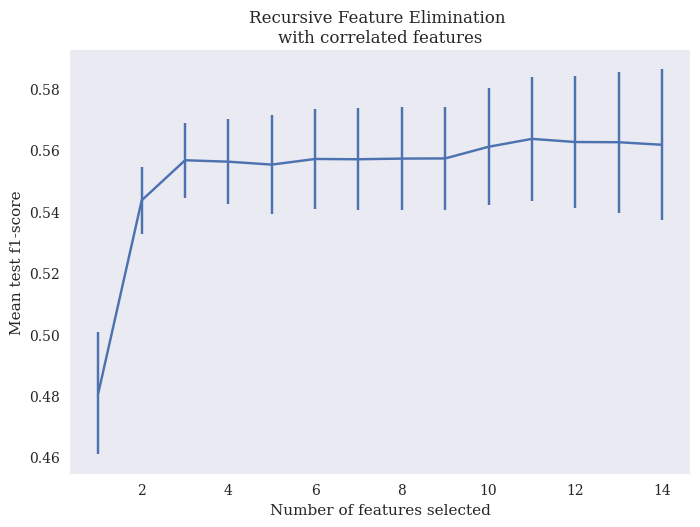

In [12]:
df_ranks, features = recursive_feature_elimination(Paths.interim + f'df_filter_{station_number}.parquet', station_number)

### Подготовленные признаки

In [80]:
# Отобранные признаки для классификации
features = ['Hmax',
 'Zmax',
 'Zmax_layer_6',
 'Zmax_layer_7',
 'Zmax_layer_8',
 'Zmax_layer_9',
 'Zmax_layer_10',
 'H_Zmax',
 'target']

Сохраняет selected_df.

In [81]:
df_filter = pd.read_parquet(Paths.interim + f'df_filter_{station_number}.parquet')
selected_df = df_filter[features]
selected_df['target'] = np.where(selected_df['target'] > 0, 1, 0)
selected_df.to_parquet(
        Paths.interim + f'selected_df_{station_number}.parquet')

## Oversampling

Для решения задачи дисбаланса классов, случаи с грозой будут увеличены в оптимальное кол-во раз.
Сохраняется в numpy_data

Scaler params: means [ 6.31458606e+03  1.78898724e+01 -1.72888661e+01 -3.97610299e+01
 -6.23564373e+01 -7.75246349e+01 -8.62523955e+01  3.41746393e+00], vars: [4.51566501e+06 1.16717871e+02 2.61178146e+03 3.22141998e+03
 2.89501788e+03 2.10047618e+03 1.41527294e+03 3.21474548e+00]
Original dataset shape Counter({0: 630921, 1: 23062})
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
Best oversampling at 2 repeat with f1: 0.56
Original dataset shape Counter({0: 630921, 1: 23062})
Resampled dataset shape Counter({0: 630921, 1: 69186})
Accuracy is 0.9665
f1_score is 0.5614
precision_score is 0.608
recall_score is 0.5214
roc_auc_score is 0.7938
HSS is 0.5441
ETS is 0.3737
CSI is 0.3902
sedi is 0.764


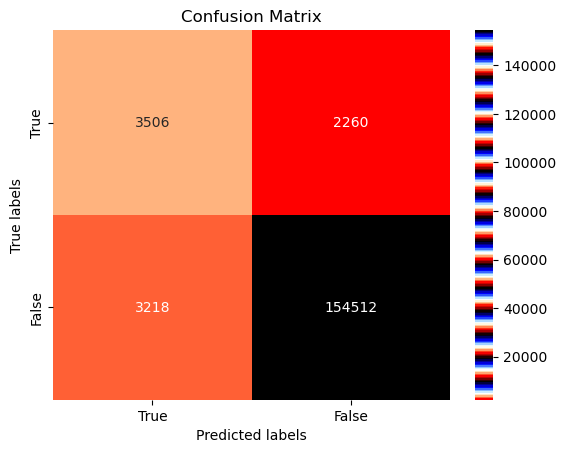

In [2]:
oversampler_and_scaler(Paths.interim + f'selected_df_{station_number}.parquet', station_number)

## Machine learning

Работа с моделями.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
from DWR_preprocess import *
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import  SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

station_number = 26061
window = 5

In [2]:
X_train =  np.load(Paths.data + f"X_train_{station_number}.npy")
y_train =  np.load(Paths.data + f"y_train_{station_number}.npy")
X_test =   np.load(Paths.data + f"X_test_{station_number}.npy")
y_test =   np.load(Paths.data + f"y_test_{station_number}.npy")

In [3]:
# баланс классов на тесте
np.unique(y_test, return_counts=True)

(array([0, 1]), array([157730,   5766]))

Accuracy is 0.967
f1_score is 0.5584
precision_score is 0.5921
recall_score is 0.5284
roc_auc_score is 0.7864
HSS is 0.5413
ETS is 0.3711
CSI is 0.3874
sedi is 0.767
CPU times: user 1.3 s, sys: 12.3 ms, total: 1.31 s
Wall time: 1.31 s


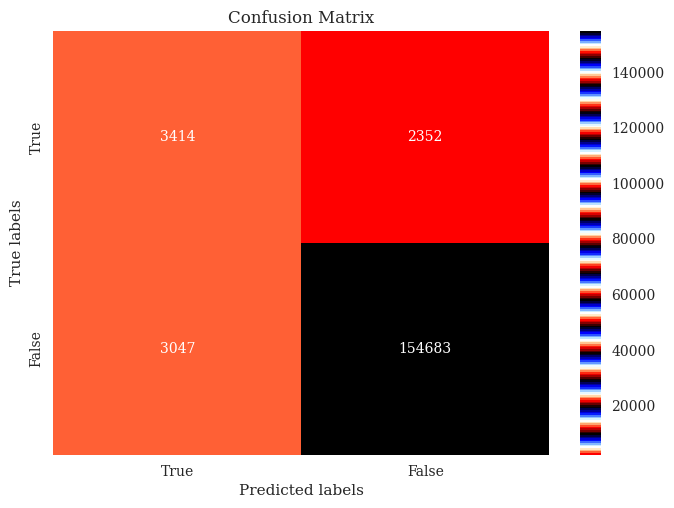

In [4]:
%%time
#classificator 
sgd = SGDClassifier(penalty='elasticnet',loss="log", n_jobs = -1, random_state=4200) 
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)


# get scores
sgd_res = scorer(y_test, sgd_pred)

Получение коэффицентов ур-ия. Описание в файле -  классификация_гроз_коэффициенты.txt

In [5]:
sgd.coef_, sgd.intercept_

(array([[0.54266458, 0.93129322, 0.54403173, 0.41041373, 0.24945749,
         0.19808833, 0.11543855, 0.29129233]]),
 array([-4.87668931]))

In [6]:
features = ['Hmax',
 'Zmax',
 'Zmax_layer_6',
 'Zmax_layer_7',
 'Zmax_layer_8',
 'Zmax_layer_9',
 'Zmax_layer_10',
 'H_Zmax']

In [7]:
result = np.dot(X_test,sgd.coef_.T)+sgd.intercept_

In [8]:
preds = np.where(result >= 0, 1,0)

Использование различных алгортимов "из коробки".

Accuracy is 0.9723
f1_score is 0.5977
precision_score is 0.5831
recall_score is 0.6132
roc_auc_score is 0.7848
HSS is 0.5834
ETS is 0.4119
CSI is 0.4263
sedi is 0.8211
CPU times: user 3min 2s, sys: 762 ms, total: 3min 3s
Wall time: 18 s


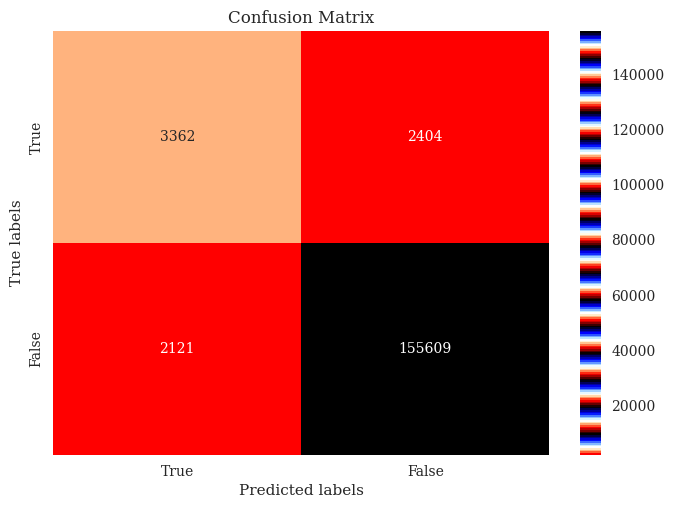

In [42]:
%%time
#classificator 
rf = RandomForestClassifier(n_jobs = -2) 
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# get scores
rf_res = scorer(y_test, rf_pred)

Accuracy is 0.9622
f1_score is 0.5569
precision_score is 0.6738
recall_score is 0.4746
roc_auc_score is 0.8233
HSS is 0.5378
ETS is 0.3678
CSI is 0.3859
sedi is 0.7395
CPU times: user 43.2 s, sys: 28.8 ms, total: 43.2 s
Wall time: 8.08 s


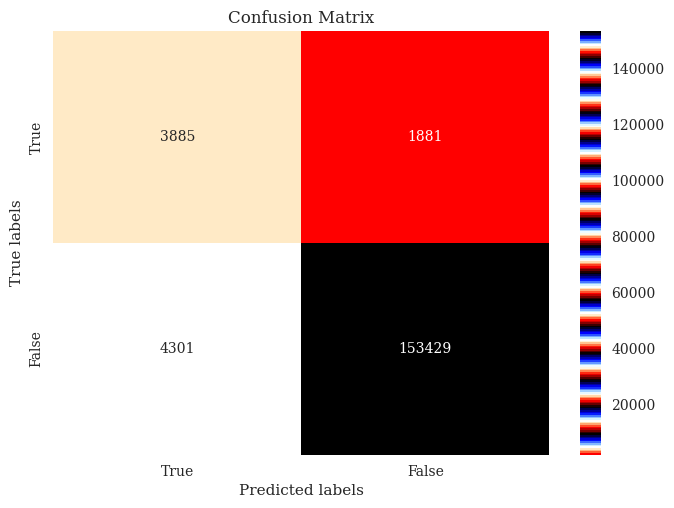

In [43]:
%%time
#classificator 
knn = KNeighborsClassifier(n_neighbors=9,leaf_size=5, n_jobs = -2) 
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# get scores
knn_res = scorer(y_test, knn_pred)

In [45]:
from catboost import CatBoostClassifier

Accuracy is 0.9682
f1_score is 0.5904
precision_score is 0.6507
recall_score is 0.5404
roc_auc_score is 0.8152
HSS is 0.574
ETS is 0.4026
CSI is 0.4189
sedi is 0.7818
CPU times: user 5min 7s, sys: 15 s, total: 5min 22s
Wall time: 44.4 s


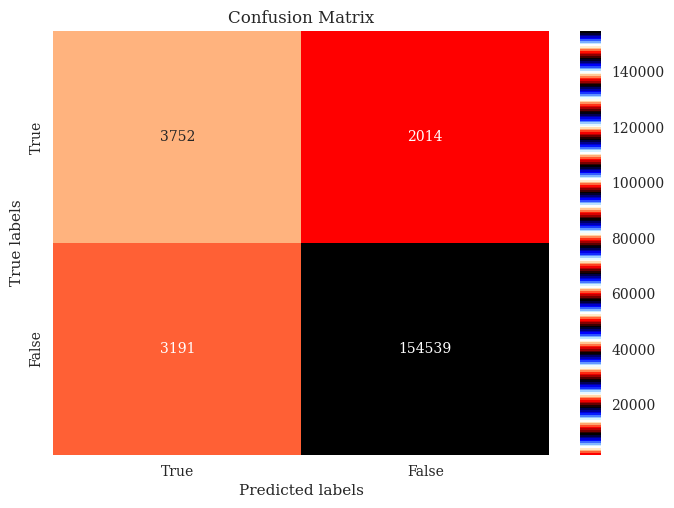

In [46]:
%%time
#classificator 
catbc = CatBoostClassifier(verbose=0) 
catbc.fit(X_train, y_train)
catbc_pred = catbc.predict(X_test)

# get scores
catbc_res = scorer(y_test, catbc_pred)

Итоговые таблицы метрик

In [ ]:
metrics = pd.Series(['acc', 'f1', 'pre', 'rec', 'roc_auc', 'hss', 'ets', 'csi', 'sedi'])
df = pd.concat([Y_res, sgd_res, knn_res, catbc_res, rf_res, metrics],
               axis=1,
               keys=['Y_param', "SGDClassifier", 'KNeighborsClassifier', 'CatBoostClassifier','RandomForestClassifier', 'metrics']).set_index('metrics')
df.T

metrics,acc,f1,pre,rec,roc_auc,hss,ets,csi,sedi
Y_param,0.999308,0.136207,0.160910,0.118080,0.580251,0.135869,0.072886,0.073081,0.590143
SGDClassifier,0.976412,0.620768,0.596602,0.646973,0.792858,0.608616,0.437418,0.450082,0.845137
KNeighborsClassifier,0.976135,0.653857,0.696557,0.616089,0.841021,0.641546,0.472262,0.485726,0.836171
CatBoostClassifier,0.978000,0.668328,0.684997,0.652452,0.836398,0.656958,0.489157,0.501872,0.855234
RandomForestClassifier,0.980525,0.684142,0.651785,0.719879,0.821652,0.674120,0.508432,0.519921,0.887839


In [ ]:
metrics = pd.Series(['acc', 'f1', 'pre', 'rec', 'roc_auc', 'hss', 'ets', 'csi', 'sedi'])
df = pd.concat([Y_res, sgd_res, knn_res, catbc_res, rf_res, metrics],
               axis=1,
               keys=['Y_param', "SGDClassifier", 'KNeighborsClassifier', 'CatBoostClassifier','RandomForestClassifier', 'metrics']).set_index('metrics')
df.T

metrics,acc,f1,pre,rec,roc_auc,hss,ets,csi,sedi
Y_param,0.999308,0.136207,0.160910,0.118080,0.580251,0.135869,0.072886,0.073081,0.590143
SGDClassifier,0.974953,0.627989,0.653318,0.604551,0.819514,0.615050,0.444095,0.457714,0.825357
KNeighborsClassifier,0.975759,0.645339,0.681548,0.612783,0.833573,0.632826,0.462872,0.476384,0.832828
CatBoostClassifier,0.977371,0.658367,0.673820,0.643607,0.830671,0.646671,0.477838,0.490720,0.849451
RandomForestClassifier,0.979362,0.672461,0.654723,0.691187,0.822470,0.661815,0.494561,0.506547,0.873424


#### Нейронные сети
Неоконченный проект

In [2]:
from DWR_preprocess import *
from matplotlib import cm
import matplotlib.colors
import plotly.graph_objects as go

window_shape = 5
station_number = 26061

In [3]:
all_data = np.concatenate(get_npy_file(onlyfiles(Paths.data + f'lightning_stack_{station_number}')), axis=0)

100%|██████████| 169/169 [00:01<00:00, 128.30it/s]


11 layers of reflectivity, Hmax, phen, iso22, iso0, data, x, y, tropopause, target

In [4]:
all_data.shape

(817479, 5, 5, 20)

In [5]:
labels = all_data[:, all_data.shape[1] // 2, all_data.shape[1] // 2, -1].reshape(
        all_data.shape[0], -1
    )
binary_labels = np.where(labels>0,1,0)

In [6]:
np.unique(labels, return_counts=True), np.unique(binary_labels, return_counts=True)

((array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 20],
        dtype=int32),
  array([788502,  24564,   3256,    805,    202,     91,     31,     13,
              4,      6,      1,      1,      2,      1])),
 (array([0, 1]), array([788502,  28977])))

In [7]:
np.unique(binary_labels, return_index=True)

(array([0, 1]), array([    0, 47672]))

In [8]:
data_to_plot = all_data[:, :, :, :11].mean(axis=0)

In [9]:
X, Y, Z =  np.indices(np.array(data_to_plot.shape) + 1).astype(float)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=data_to_plot.flatten(),
    opacity=0.5,
    ))
fig.show()

/tmp/ipykernel_4644/4060969970.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(m, shrink=0.5)


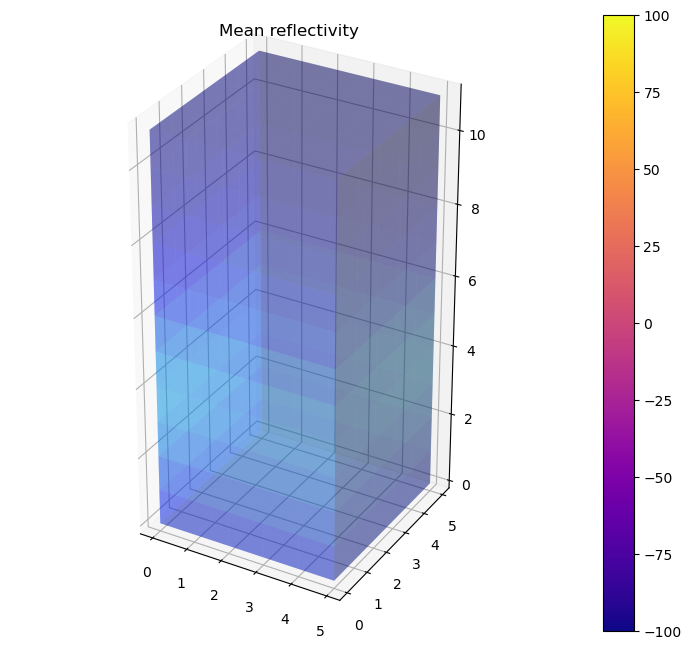

In [10]:


x, y, z =  np.indices(np.array(data_to_plot.shape) + 1).astype(float)
ax = plt.figure(figsize=(9,16)).add_subplot(projection='3d')

colors = plt.cm.plasma(data_to_plot)
norm = matplotlib.colors.Normalize(vmin=-100, vmax=100)

ax.voxels(x, y, z, data_to_plot, alpha=0.3,facecolors=plt.cm.jet(norm(data_to_plot)))

m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
m.set_array([])
plt.colorbar(m, shrink=0.5)
plt.title('Mean reflectivity')
ax.set_aspect('equal')

In [11]:
data = all_data
# Assuming you have a 3D data array named 'data' with shape (depth, height, width)
# Normalize the data by subtracting the mean and dividing by the standard deviation
mean = np.mean(data, axis= (0,1,2))
std = np.std(data, axis= (0,1,2))
normalized_data = (data - mean) / std

# Convert the normalized data to a PyTorch tensor
tensor_data = torch.from_numpy(normalized_data)

# Print the shape of the tensor to verify
print(tensor_data.shape)


torch.Size([817479, 5, 5, 20])


In [12]:
# Assuming your tensor_data has shape torch.Size([817479, 5, 5, 20])
indices_to_delete = [14, 15, 16, 17, 18, 19]  # Example indices to delete

## Оставляем только отражаемость, максимальную высоту, явление, высота изотермы -22

# Create a boolean mask to identify the arrays to keep
mask = torch.ones(tensor_data.shape[-1], dtype=torch.bool)
mask[indices_to_delete] = 0

# Use the mask to select and keep the desired arrays along the last dimension
sliced_tensor_data = tensor_data[..., mask]

# Print the shape of the sliced tensor to verify
print(sliced_tensor_data.shape)

torch.Size([817479, 5, 5, 14])


In [13]:
tensor_data = sliced_tensor_data.permute(0, 3, 1, 2)
tensor_data.shape

torch.Size([817479, 14, 5, 5])

In [14]:
cuda0 = torch.device('cuda:0')

In [15]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(tensor_data.to(dtype=torch.float32), torch.from_numpy(binary_labels.reshape(-1)).to(dtype=torch.int64))

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define your CNN model
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self):
        
        super(Network, self).__init__()
        Cin = 14
        init_f = 32
        h = 5
        w = 5
        num_fc1 = 100
        num_classes = 2
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

# Instantiate your SimpleCNN model
model = Network()

# Print the model architecture
print(model)


Network(
  (conv1): Conv2d(14, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [38]:
batch_size = 32

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)


In [50]:
# Instantiate your SimpleCNN model
model = Network()

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    # Set model in training mode
    model.train()

    # Iterate over the dataloader for each batch
    for batch_data, batch_labels in train_dataloader:
        # Move the batch data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_data)

        # Compute the loss
        loss = criterion(outputs, batch_labels.reshape(-1,1).to(dtype=torch.float32))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the loss for monitoring the training progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), "simple_cnn_model.pth")

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [40]:
# Make predictions
all_predictions = []

with torch.no_grad():
    for batch_data, _ in test_dataloader:
        # Move the batch data to the device
        batch_data = batch_data.to(device)

        # Forward pass
        predictions = model(batch_data)

        # Get the predicted class labels
        predicted_labels = predictions#predictions.argmax(dim=1)

        # Convert the predicted labels to a numpy array
        predicted_labels = predicted_labels.cpu().numpy()

        # Collect all predictions
        all_predictions.extend(predicted_labels.tolist())


Accuracy is 0.0595
f1_score is 0.1123
precision_score is 1.0
recall_score is 0.0595
roc_auc_score is 0.5
HSS is 0.0
ETS is 0.0
CSI is 0.0595
sedi is nan


/home/meteofurletov/iram/lightning/notebooks/DWR_preprocess.py:360: RuntimeWarning: invalid value encountered in long_scalars
  f = misses / (misses + correctnegatives)


0    0.059482
1    0.112284
2    1.000000
3    0.059482
4    0.500000
5    0.000000
6    0.000000
7    0.059482
8         NaN
dtype: float64

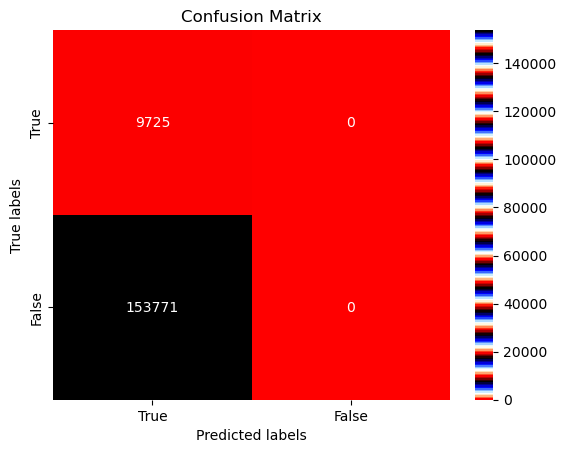

In [44]:
scorer(binary_labels[int(0.8*binary_labels.shape[0]):].reshape(-1), np.where(np.array(all_predictions) > 0.5, 1, 0))